# BATTLE OF THE NEIGHBORHOODS/BOROUGHS

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request,urllib.parse , requests
import re 
import geocoder
import folium
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from geopy.geocoders import Nominatim



## Toronto data scarper

- Read the table data from wikipedia using BeautifulSoup and convert it to a dataframe using `pd.read_html` 

- Create a dictionary and loop through all cells and use `regex` to extract the data for the necessary columns since each cell has data in text fomart
- First 3 letters are the **PostalCode**
- **Boroughs** are the next letters before the bracket
- **Neighbourhoods** are inside the brackets
- Replace the slashes with commas and set the Neighbourhoods as one string

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = urllib.request.urlopen(url).read()
soup = BeautifulSoup(data,'lxml')
soup_data = soup.find_all('table')

df = pd.read_html(str(soup_data))[0]

data_dict = {
    'PostalCode':[],
    'Borough':[],
    'Neighborhood':[]
    }

for i in range(len(df.columns)):
    for j in range(len(df)):
        postal_code = df[i][j][0:3]
        borough = re.findall('^[^\(]+',df[i][j][3:] )[0] 
        if borough != 'Not assigned':
            neighborhoods = re.findall('(?<=[(])[^\)]+',df[i][j][3:])[0].split(' / ')
            data_dict['PostalCode'].append(postal_code)
            data_dict['Borough'].append(borough)
            data_dict['Neighborhood'].append(','.join(neighborhoods)) 

dataframe = pd.DataFrame(data_dict)

# We will download the GeoSpatialDataset.csv file and concat it with the wikipedia data to get all geodata for all available postal codes
# BUT SINCE I ALREADY HAVE THIS DATASET I WILL COMMENT OUT THE CODE
# url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'

#r = requests.get(url, allow_redirects=True)
#open('GeoSpatialDataset.csv', 'wb').write(r.content)

geodata = pd.read_csv('GeoSpatialDataset.csv')
geodata = geodata.rename(columns = {'Postal Code':'PostalCode'})
toronto_neighborhoods = pd.merge(dataframe,geodata ,on='PostalCode')
toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill,Port Union,Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Newyork data scrap

In [3]:
# SINCE I ALREADY HAVE THIS DATASET I WILL COMMENT OUT THE CODE
# url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'

#r = requests.get(url, allow_redirects=True)
#open('newyork_data.json', 'wb').write(r.content)

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)


neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
newyork_neighborhoods = pd.DataFrame(columns=column_names)


for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_neighborhoods = newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

newyork_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Visualize toronto Neighbourhoods

In [4]:
def view_neighborhoods(user_agent,town_name,df):
    geolocator = Nominatim(user_agent=user_agent)
    location = geolocator.geocode(town_name)
    latitude_ ,longitude_ = location.latitude, location.longitude 

    map_ = folium.Map(location=[latitude_, longitude_], zoom_start=10)

    # add markers to map
    for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood'] ):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],  radius=5,  popup=label, color='blue', fill=True,  fill_color='#3186cc',   fill_opacity=0.7,
        parse_html=False).add_to(map_) 
        
    display(map_)

    return latitude_, longitude_

In [5]:
toronto_latitude, toronto_longitude = view_neighborhoods('toronto_explorer','Toronto,ON', toronto_neighborhoods)

## Visualize Newyork Neighbourhoods

In [6]:
newyork_latitude, newyork_longitude = view_neighborhoods('newyork_explorer','New York City, NY', newyork_neighborhoods)

Setting up our Foursquare api call

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210430' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500


## Function to get venue data

In [8]:
def get_venue_data(town_lat,town_long,df):
    columns_to_pick = ['venue.name','venue.categories','venue.location.lat','venue.location.lng']
    venue_data = pd.DataFrame(columns=['Borough','Neighborhood']+columns_to_pick)
    for borough,neighborhood,lat,longt in zip(df['Borough'],df['Neighborhood'],df['Latitude'],df['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( 
            CLIENT_ID, CLIENT_SECRET, VERSION, town_lat, town_long, radius, LIMIT )
        try:
            venues = requests.get(url).json()['response']['groups'][0]['items']
            norm_df = pd.json_normalize(venues)[columns_to_pick]
            venue_data = pd.concat([venue_data , norm_df ],axis=0)
            venue_data.iloc[-len(norm_df):,0],venue_data.iloc[-len(norm_df):,1] = borough,neighborhood
        except:
            pass


    venue_data['venue.categories'] = venue_data['venue.categories'].apply(lambda x:x[0]['name'])
    venue_data = venue_data.reset_index(drop=True)
    venue_data.columns = ['Borough','Neighborhood','name','category','latitude','longitude']
    return(venue_data)

## Toronto Venue Data

In [9]:
toronto_venue_data = get_venue_data(toronto_latitude,toronto_longitude,toronto_neighborhoods)
toronto_venue_data.head()

,Borough,Neighborhood,name,category,latitude,longitude
0,Scarborough,"Malvern,Rouge",Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Scarborough,"Malvern,Rouge",Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Scarborough,"Malvern,Rouge",Poke Guys,Poke Place,43.654895,-79.385052
3,Scarborough,"Malvern,Rouge",Textile Museum of Canada,Art Museum,43.654396,-79.386500
4,Scarborough,"Malvern,Rouge",Old City Hall,Monument / Landmark,43.652009,-79.381744


## Newyork Venue Data

In [10]:
newyork_venue_data = get_venue_data(newyork_latitude, newyork_longitude, newyork_neighborhoods)
newyork_venue_data.head()

,Borough,Neighborhood,name,category,latitude,longitude
0,Bronx,Wakefield,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
1,Bronx,Wakefield,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
2,Bronx,Wakefield,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272
3,Bronx,Wakefield,City Hall Park,Park,40.712359,-74.007493
4,Bronx,Wakefield,Gibney Dance Center Downtown,Dance Studio,40.713923,-74.005661


## Check the top 10 categories of each town

In [11]:
plt.rcParams['figure.figsize']=(12,5)

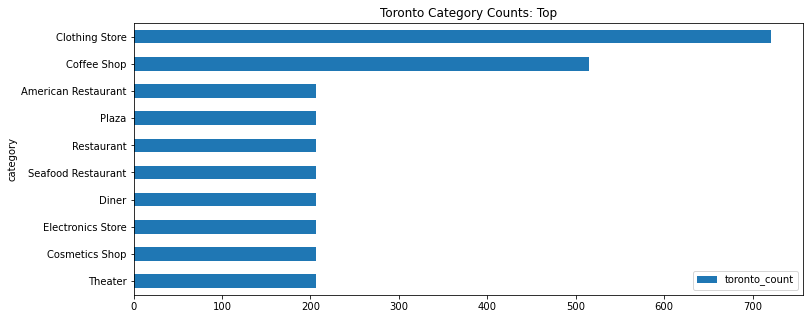

In [12]:
cat_count_toronto = toronto_venue_data.groupby(['category'])['category'].count().reset_index(name="toronto_count")
cat_count_toronto.sort_values('toronto_count', ascending=True).tail(10).set_index('category').plot(kind="barh",title='Toronto Category Counts: Top')

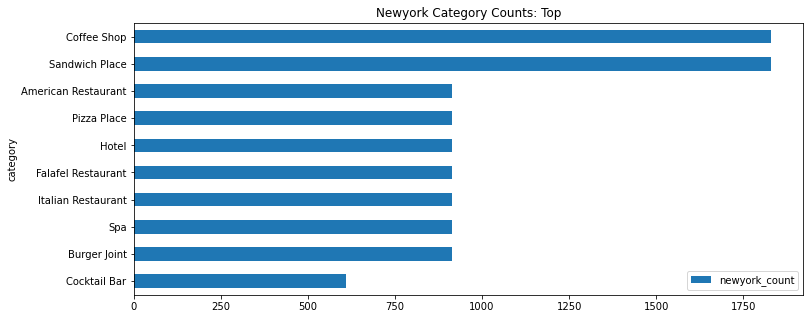

In [13]:
cat_count_newyork = newyork_venue_data.groupby(['category'])['category'].count().reset_index(name="newyork_count")
cat_count_newyork.sort_values('newyork_count', ascending=True).tail(10).set_index('category').plot(kind="barh",title='Newyork Category Counts: Top')

We Combine the counts in both towns and order the dataframe depending on which town we would like to use as a comparison to the other, also there are some categories in one town that are not in the other , we will see which 

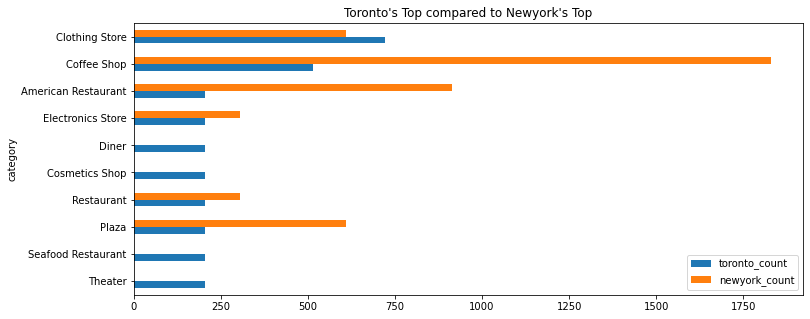

In [14]:
mereged_cat_count_df = pd.merge(cat_count_toronto,cat_count_newyork,how='outer', on='category').fillna(0)
mereged_cat_count_df.sort_values('toronto_count', ascending=True).tail(10).set_index('category').plot(kind="barh",title="Toronto's Top compared to Newyork's Top")

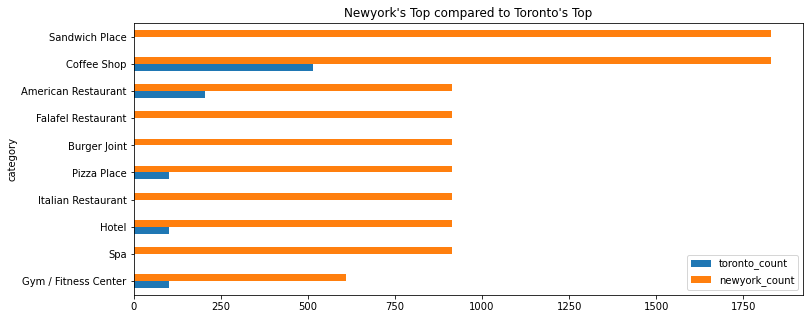

In [15]:
mereged_cat_count_df.sort_values('newyork_count', ascending=True).tail(10).set_index('category').plot(kind="barh",title= "Newyork's Top compared to Toronto's Top")

In [16]:
mereged_cat_count_df.sort_values(['newyork_count','toronto_count'], ascending=False).head(10)

,category,toronto_count,newyork_count
9,Coffee Shop,515.0,1830.0
86,Sandwich Place,0.0,1830.0
0,American Restaurant,206.0,915.0
22,Hotel,103.0,915.0
35,Pizza Place,103.0,915.0
61,Burger Joint,0.0,915.0
68,Falafel Restaurant,0.0,915.0
75,Italian Restaurant,0.0,915.0
88,Spa,0.0,915.0
7,Clothing Store,721.0,610.0


## Check those at the bottom

In [17]:
mereged_cat_count_df.sort_values('toronto_count').head(10)

,category,toronto_count,newyork_count
94,Yoga Studio,0.0,610.0
70,Fried Chicken Joint,0.0,305.0
69,French Restaurant,0.0,610.0
68,Falafel Restaurant,0.0,915.0
67,Discount Store,0.0,305.0
66,Dance Studio,0.0,305.0
65,Cuban Restaurant,0.0,305.0
64,Coworking Space,0.0,305.0
63,Cajun / Creole Restaurant,0.0,305.0
62,Burrito Place,0.0,305.0


In [18]:
mereged_cat_count_df.sort_values('newyork_count').head(10)

,category,toronto_count,newyork_count
47,Tanning Salon,103.0,0.0
25,Middle Eastern Restaurant,103.0,0.0
26,Modern European Restaurant,103.0,0.0
28,Movie Theater,103.0,0.0
29,Music Venue,103.0,0.0
30,Neighborhood,103.0,0.0
31,New American Restaurant,103.0,0.0
32,Noodle House,103.0,0.0
33,Office,103.0,0.0
34,Opera House,103.0,0.0


In [19]:
mereged_cat_count_df.sort_values(['newyork_count','toronto_count']).head(10)

,category,toronto_count,newyork_count
1,Art Museum,103.0,0.0
2,Bank,103.0,0.0
10,Colombian Restaurant,103.0,0.0
12,Concert Hall,103.0,0.0
14,Department Store,103.0,0.0
18,Food & Drink Shop,103.0,0.0
20,Gastropub,103.0,0.0
23,Latin American Restaurant,103.0,0.0
24,Mexican Restaurant,103.0,0.0
25,Middle Eastern Restaurant,103.0,0.0


## Quite noticably those at the bottom of one state are likely non existent in the other 

In [20]:
#Number of Categories in newyork vs toronto
len(newyork_venue_data['category'].unique()),len(toronto_venue_data['category'].unique())

(63, 54)

# PART 2
### Probabilities

In [21]:
#you can printout the lists below to get categories to select from
newyork_categories = newyork_venue_data['category'].unique()
toronto_categories = toronto_venue_data['category'].unique()
#print(newyork_categories)
#print(toronto_categories)

## Using : <br>
## Conditional probability
![conditional provbability](http://www.stat.yale.edu/Courses/1997-98/101/cond.gif)
<br>
## Bayes Theorem
![Bayes Theorem](https://cdn.corporatefinanceinstitute.com/assets/bayes-theorem2-600x97.png)


In [22]:
list_of_categories = ['American Restaurant','Bookstore','Breakfast Spot']
#Sort by neighborhood or borough ?
sortby = 'Borough'

In [27]:
def preference_prob(row):
    # probability of the next given the previous:
    for i in range(len(row)-1):
        prob_next_given_prev = np.prod(row[:i+1]) / row[i+1]
        prob_next = row[i+1]
        prob_next_given_c_prev= np.prod(row[:i+1]) / (1 - row[i+1])  
        prob_c_next = 1 - np.prod(row[:i+1]) 
        denominator = prob_next_given_c_prev*prob_c_next + prob_next_given_prev*prob_next
        # prob of next preferences given previous
        row[i+1] = (prob_next_given_prev * prob_next)  /  denominator
    return round(row[-1],3)*100


In [28]:
def prob_location_preference(df, count_column_name,list_of_categories,sortby ):
    grouped = df.groupby(['category',sortby])['category'].count().reset_index(name=count_column_name).pivot(index=sortby,values=count_column_name,columns='category')
    # probability of finding category x in that certain town as oppose to the all existing counts of category x
    probability_df = grouped/grouped.sum()


    if len(list_of_categories)== 0:
        print("No category entered")
        pass
    elif len(list_of_categories)== 1:
        preference_df= probability_df[list_of_categories[0]].sort_values().head(10) # return the top 10
        plt.figure(figsize=(15,10))
        plt.barh(preference_df.index, preference_df.values)
        plt.title('Places with highest likelyhood of\n having/finding a/an {}'.format(list_of_categories[0]))
        plt.show()
    else:
        # we assume that the order in which the columns were entered is the order prefence of the person
        # get joint probbility
        joint_prob= probability_df[list_of_categories].apply(lambda x:round(np.prod(list(x))*100,3),axis=1).head(10).sort_values()
        # disjoint probability
        disjoint_prob = probability_df[list_of_categories].apply(lambda x:round(np.sum(list(x))*100,3),axis=1).head(10).sort_values()
        conditional_prob = probability_df[list_of_categories].apply(lambda x: preference_prob(x),axis=1).head(10).sort_values()

        plt.rcParams['font.size']=14
        plt.figure(figsize=(15,10))
        plt.barh(joint_prob.index, joint_prob.values)
        plt.title('Places with the highest probability of having your\n combination of {} and {}'.format(
            ','.join(list_of_categories[:-1]), list_of_categories[-1] ))
        plt.show()

        print('\n')
        plt.figure(figsize=(15,10))
        plt.barh(disjoint_prob.index, disjoint_prob.values)
        plt.title('Chance that atleast one of your\n preferences is in the said region/places')
        plt.show()
        print('\n')
        plt.figure(figsize=(15,10))
        plt.barh(conditional_prob.index, conditional_prob.values)
        plt.title('Chance that your sorted preference\n {} will exist'.format(','.join(list_of_categories) ) )
        plt.show()

    return




## We multiply the probabilities by 100 and turn them to percentage likelyhoods so as to make it easire to plot i.e increase smaller values 

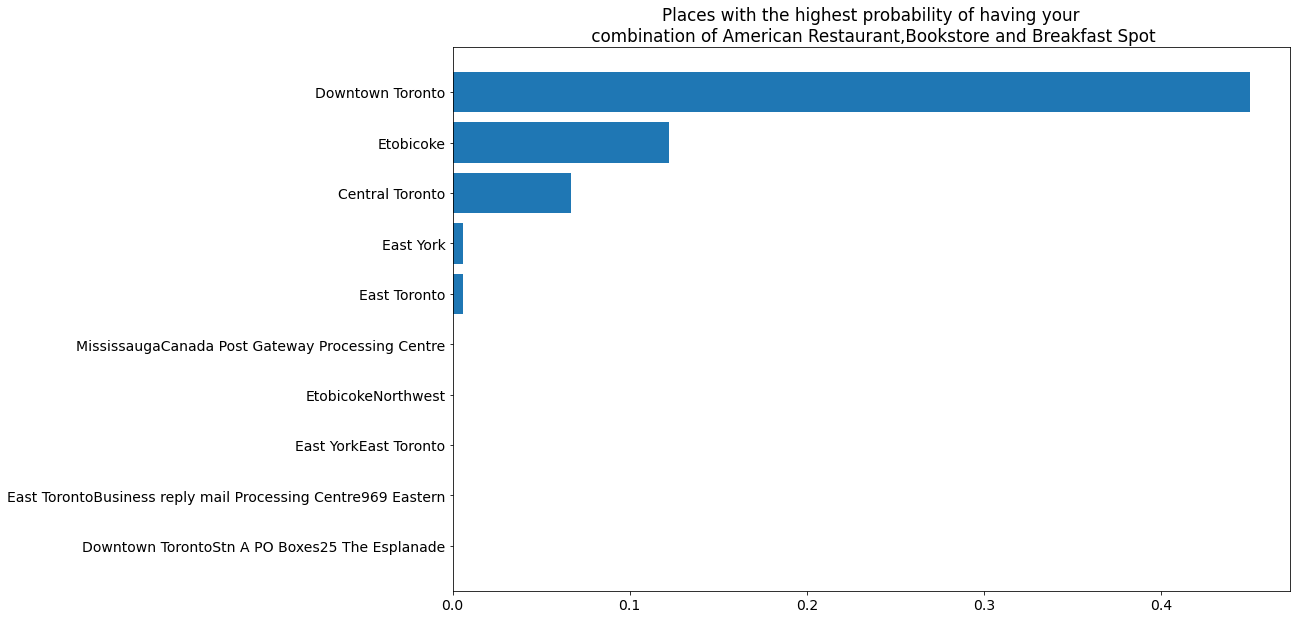

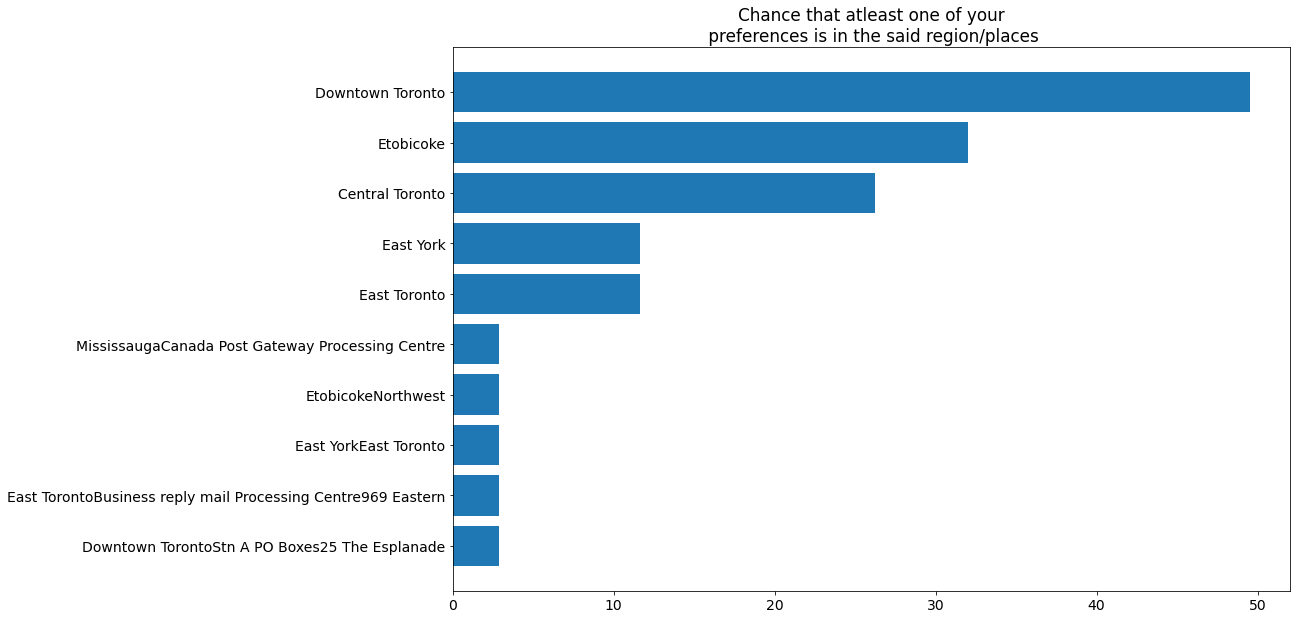

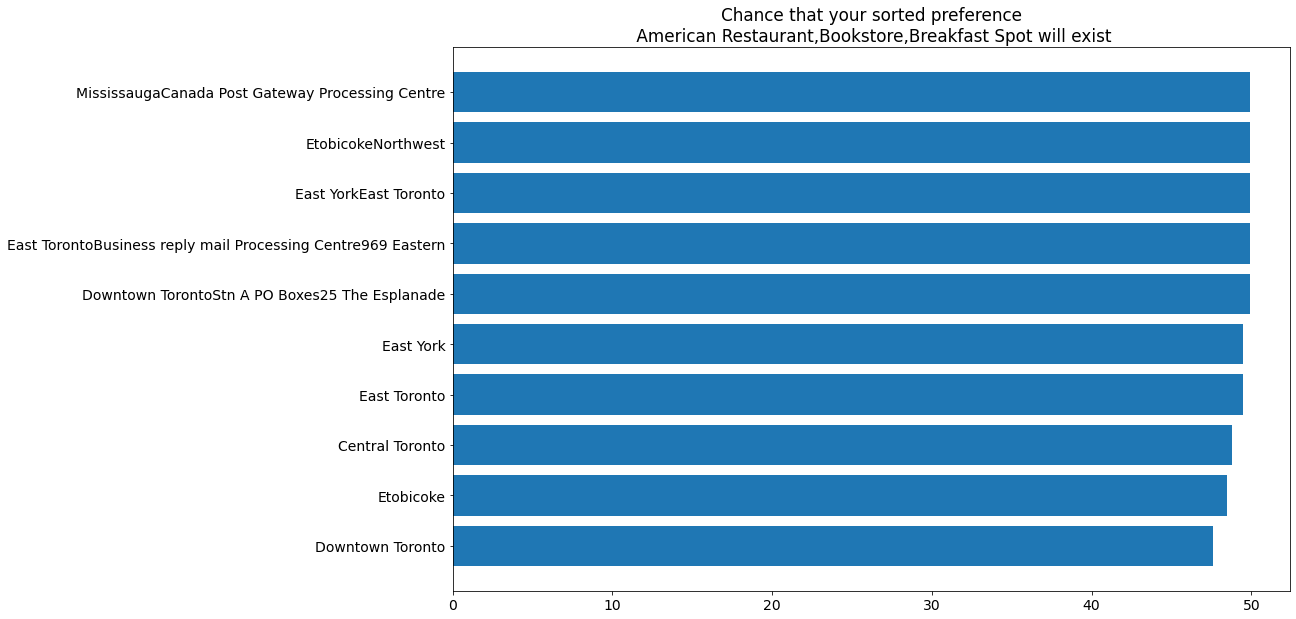

In [29]:
prob_location_preference(toronto_venue_data ,'toronto_count' ,list_of_categories, sortby )

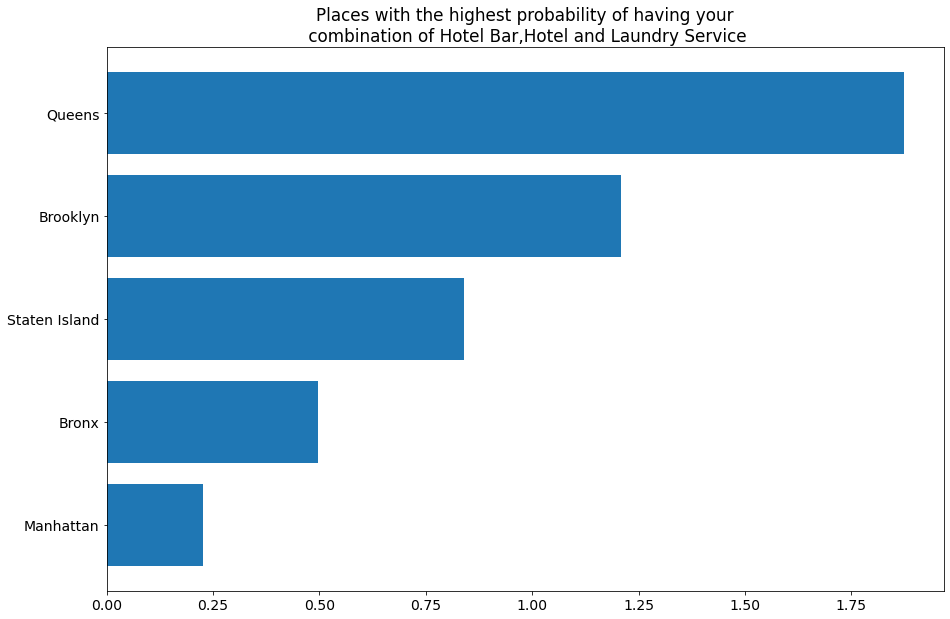

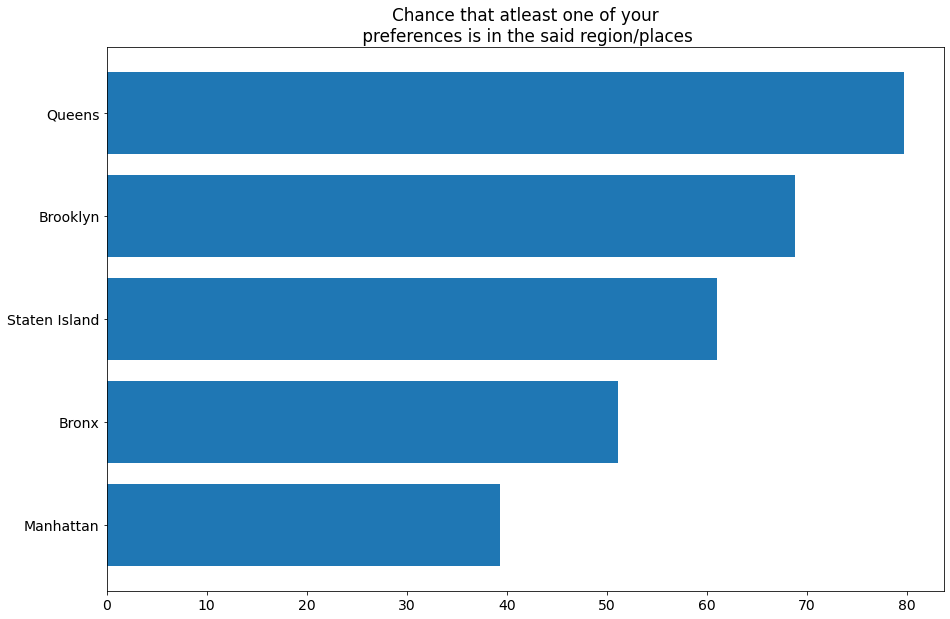

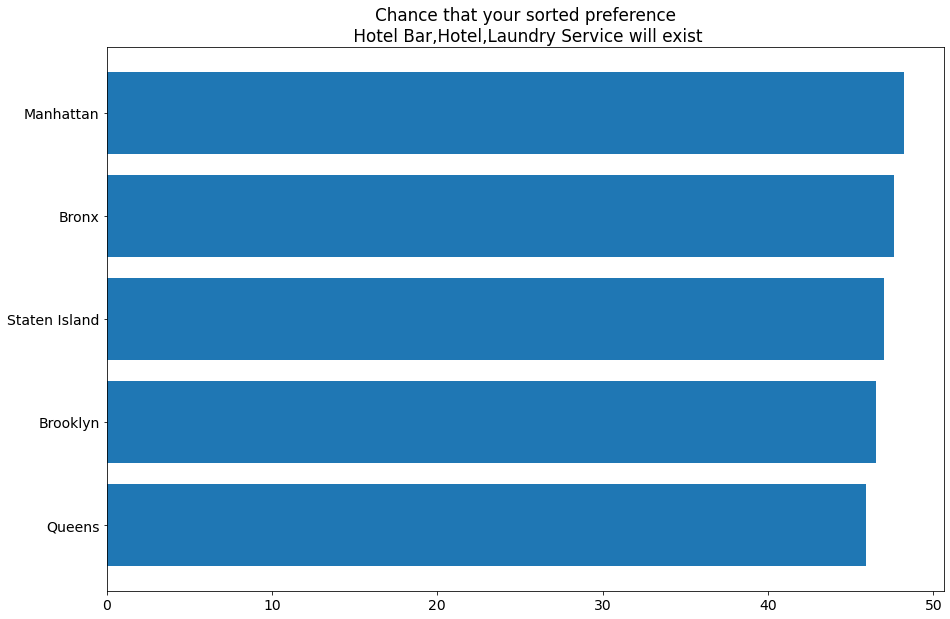

In [30]:
prob_location_preference(newyork_venue_data , 'newyork_count' ,newyork_categories[0:3],sortby )

## Now we can check for neighbourhoods in a Borough

In [31]:
sortby = 'Neighborhood'
toronto_venue_data_borough = toronto_venue_data[toronto_venue_data['Borough']=='East York' ]
newyork_venue_data_borough = newyork_venue_data[newyork_venue_data['Borough']=='Manhattan' ]

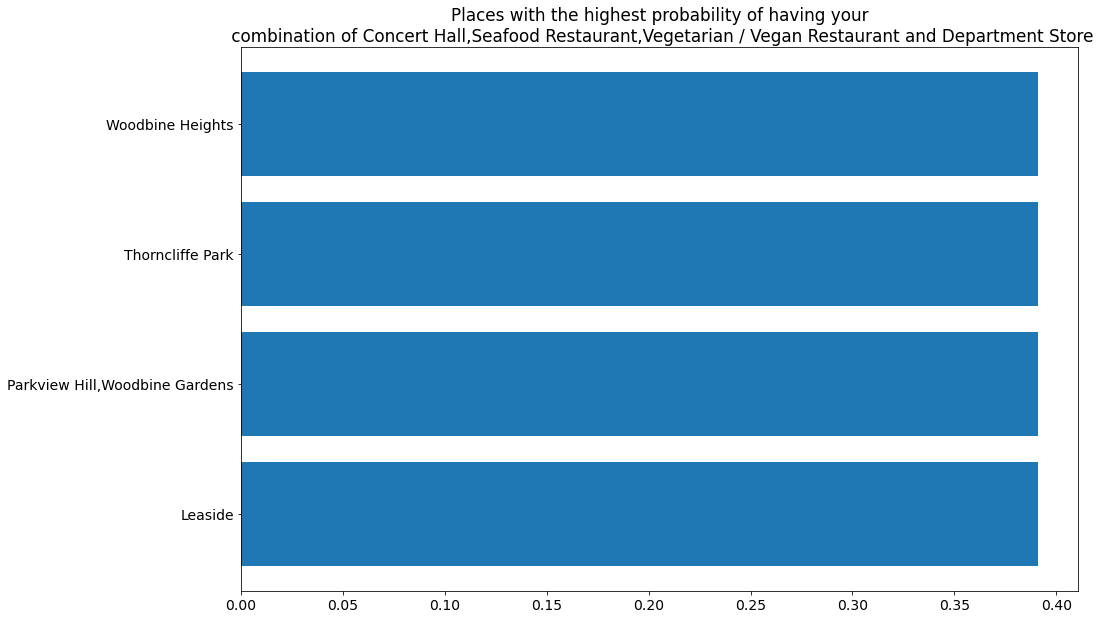

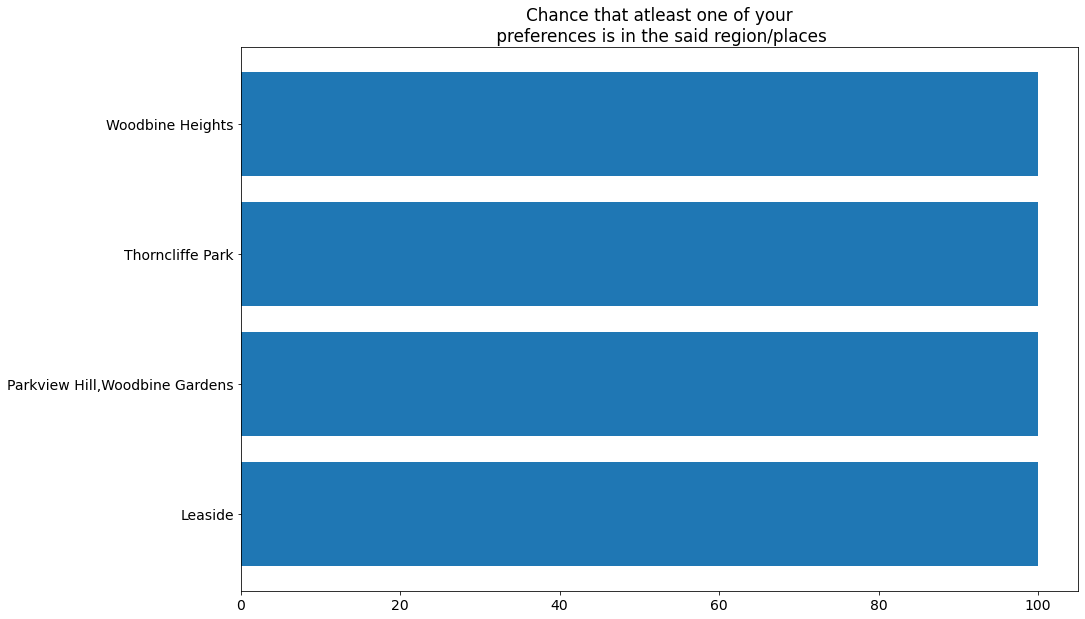

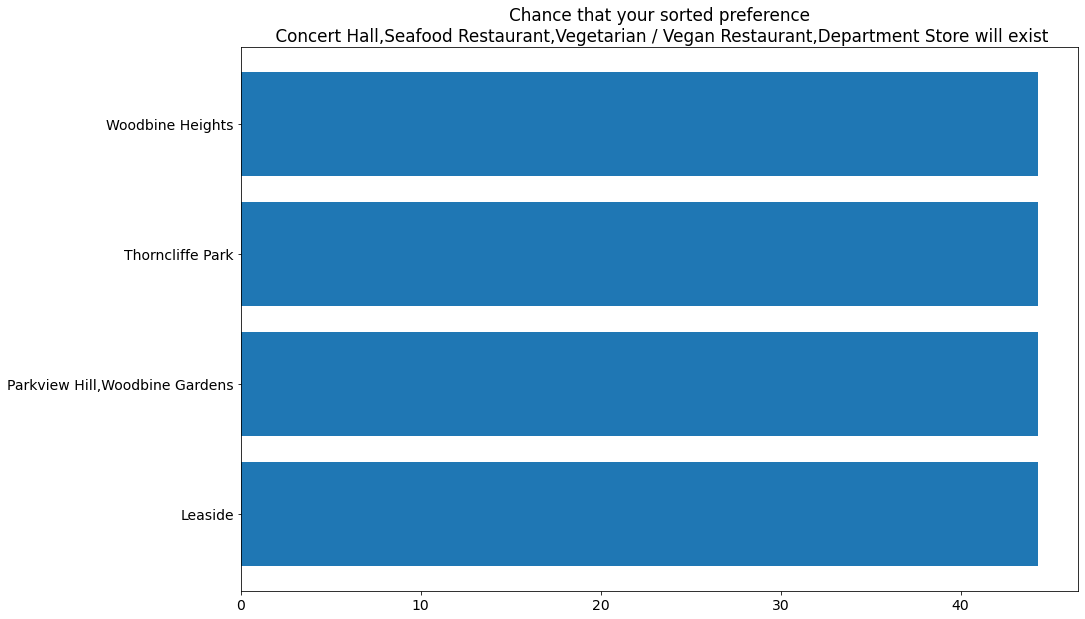

In [32]:
prob_location_preference(toronto_venue_data_borough ,'toronto_count' ,toronto_categories[14:18], sortby )

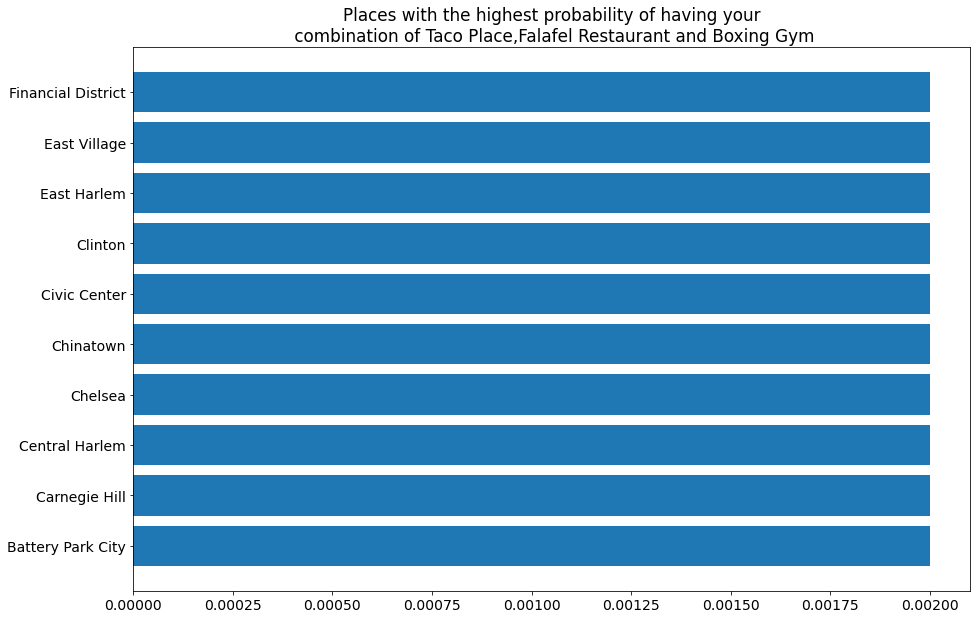

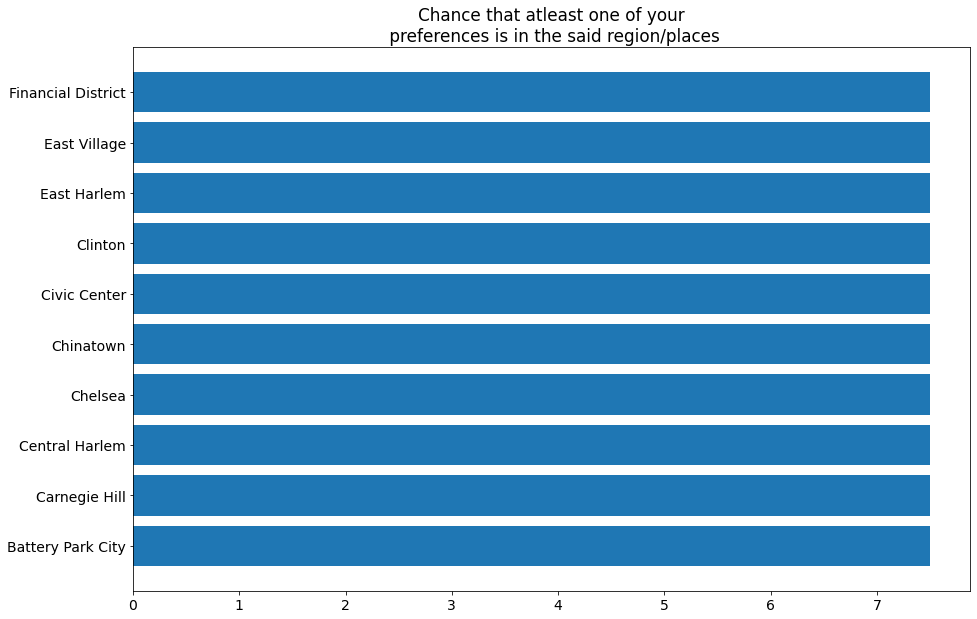

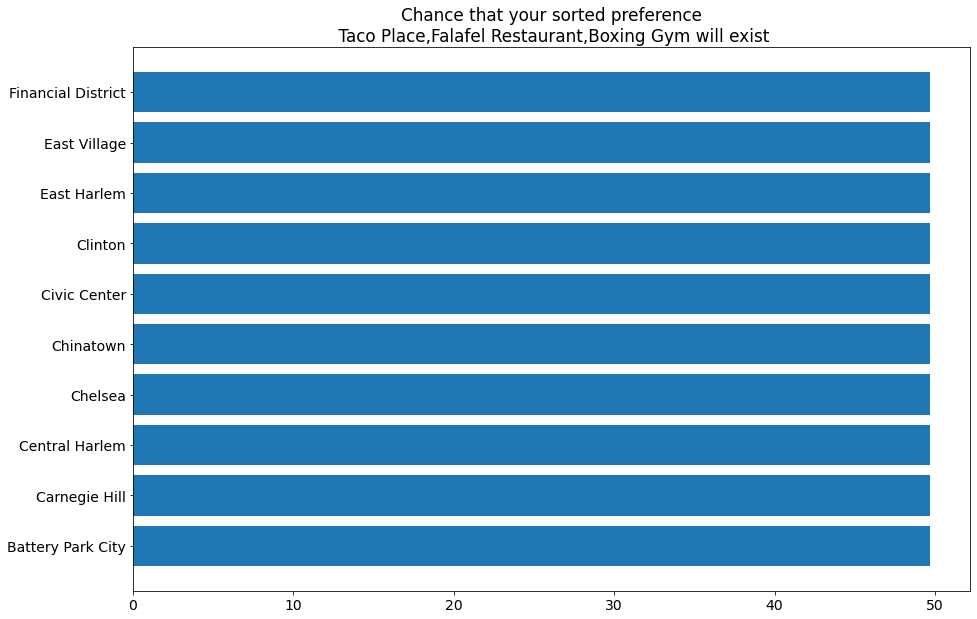

In [33]:
prob_location_preference(newyork_venue_data_borough ,'newyork_count' ,newyork_categories[9:12], sortby )

## Based on the results from the chart you can the decide where to move to

# THE END